# **Sequential Convolutional Network**

Using TensorFlow, we experiment with different ConvNet architectures on the [CIFAR10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset. The final model took inspiration from [VGG-16](https://arxiv.org/abs/1409.1556) that achieves above 70% accuracy on the test set within 10 epochs training using Adam optimizer. In particular, the architecture is the following:

(Conv32-BatchNorm-ReLU)$\times$2 - MaxPool - (Conv64-BatchNorm-ReLU)$\times$3 - MaxPool - (Conv128-BatchNorm-ReLU)$\times$3 - MaxPool - FullyConnected$\times$2

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset and perform preprocessing.

    Inputs:
    -num_training: number of training examples
    -num_validation: number of validation examples
    -num_test: number of test examples

    Output:
    a dictionary with keys 'X_train', 'y_train', 'X_val', 'y_val', 'X_test' and
    'y_test'
    """
    # Load the CIFAR-10 dataset and change data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    #X_train = np.asarray(X_train, dtype=np.float32)
    #y_train = np.asarray(y_train, dtype=np.int32).flatten()
    #X_test = np.asarray(X_test, dtype=np.float32)
    #y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    
    # Normalize the data over the channels by subtracting the mean pixel and dividing std 
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test
    }

In [4]:
data = load_cifar10()

for k, v in data.items():
  print('%s: ' % k, v.shape, v.dtype)

170500096/170498071 [==============================] - 13s 0us/step
X_train:  (49000, 32, 32, 3) float64
y_train:  (49000, 1) uint8
X_val:  (1000, 32, 32, 3) float64
y_val:  (1000, 1) uint8
X_test:  (10000, 32, 32, 3) float64
y_test:  (10000, 1) uint8


In [0]:
def conv_bn_relu(X, num_filters, filter_size=3, stride=1, pad='same'):
  regularizer = tf.keras.regularizers.l2(1e-3)

  X = tf.keras.layers.Conv2D(num_filters, filter_size, stride, pad, kernel_regularizer=regularizer)(X)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.Activation('relu')(X)
  return X

In [0]:
def CustomConvNet(input_shape=(32,32,3), num_classes=10, reg=1e-1):
  filters = [32, 64, 128]
  regularizer = tf.keras.regularizers.l2(reg)

  X_input = tf.keras.Input(input_shape)

  X = tf.keras.layers.ZeroPadding2D(padding=1)(X_input)

  # stage 1
  X = conv_bn_relu(X, filters[0])
  X = conv_bn_relu(X, filters[0])
  #X = conv_bn_relu(X, filters[0])
  X = tf.keras.layers.MaxPool2D(3,2)(X)

  # stage 2
  X = conv_bn_relu(X, filters[1])
  X = conv_bn_relu(X, filters[1])
  X = conv_bn_relu(X, filters[1])
  X = tf.keras.layers.MaxPool2D(3,2)(X)

  # stage 3
  X = conv_bn_relu(X, filters[2])
  X = conv_bn_relu(X, filters[2])
  X = conv_bn_relu(X, filters[2])
  X = tf.keras.layers.MaxPool2D(3,2)(X)
  #X = tf.keras.layers.AveragePooling2D(2,2)(X)
  
  # stage 4
  X = tf.keras.layers.Flatten()(X)
  X = tf.keras.layers.Dense(300, kernel_regularizer=regularizer)(X)
  X = tf.keras.layers.Dense(100, kernel_regularizer=regularizer)(X)
  X = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizer)(X)

  model = tf.keras.Model(X_input, X)

  return model

In [26]:
model = CustomConvNet()
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 34, 34, 3)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 34, 34, 32)        896       
_________________________________________________________________
batch_normalization_43 (Batc (None, 34, 34, 32)        128       
_________________________________________________________________
activation_43 (Activation)   (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
batch_normalization_44 (Batc (None, 34, 34, 32)        128 

In [27]:
lr = 1e-3

model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(data['X_train'], data['y_train'], batch_size=64, epochs=10,
                    validation_data=(data['X_val'], data['y_val']))

Epoch 1/10
766/766 [==============================] - 12s 16ms/step - loss: 9.1169 - acc: 0.4473 - val_loss: 1.8861 - val_acc: 0.5870
Epoch 2/10
766/766 [==============================] - 12s 15ms/step - loss: 1.6410 - acc: 0.6352 - val_loss: 1.7238 - val_acc: 0.5770
Epoch 3/10
766/766 [==============================] - 12s 15ms/step - loss: 1.3794 - acc: 0.6976 - val_loss: 1.5234 - val_acc: 0.6550
Epoch 4/10
766/766 [==============================] - 12s 15ms/step - loss: 1.2592 - acc: 0.7319 - val_loss: 1.3029 - val_acc: 0.7140
Epoch 5/10
766/766 [==============================] - 12s 15ms/step - loss: 1.1922 - acc: 0.7609 - val_loss: 1.4379 - val_acc: 0.6780
Epoch 6/10
766/766 [==============================] - 12s 15ms/step - loss: 1.1404 - acc: 0.7813 - val_loss: 1.3626 - val_acc: 0.7100
Epoch 7/10
766/766 [==============================] - 12s 15ms/step - loss: 1.1009 - acc: 0.7949 - val_loss: 1.3009 - val_acc: 0.7470
Epoch 8/10
766/766 [==============================] - 12s 15ms

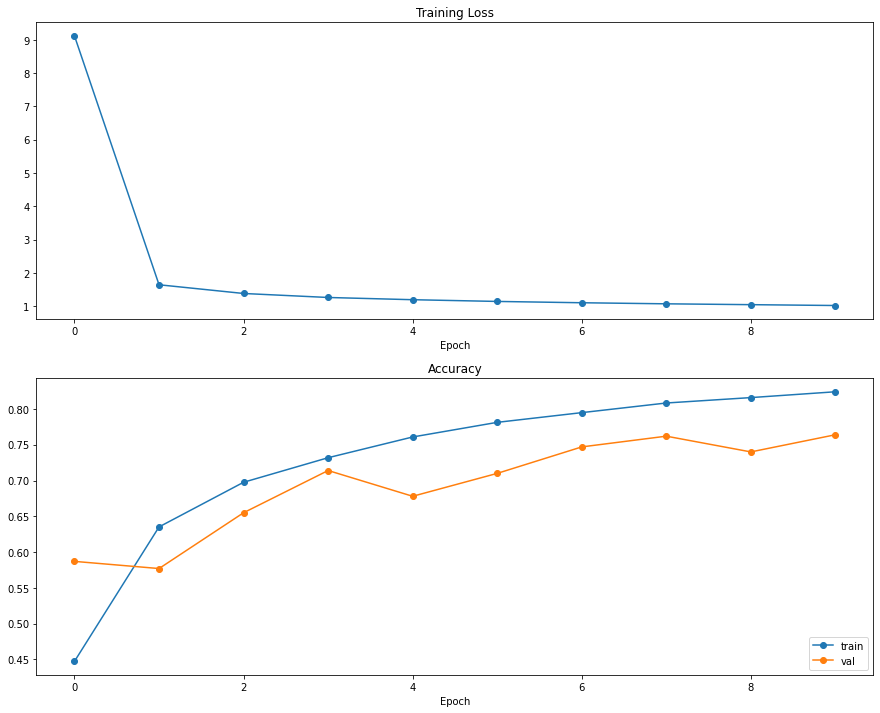

In [28]:
plt.subplot(2, 1, 1)
plt.title('Training Loss')
plt.plot(history.history['loss'], '-o')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(history.history['acc'], '-o', label='train')
plt.plot(history.history['val_acc'], '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [30]:
model.evaluate(data['X_test'], data['y_test'])

313/313 [==============================] - 1s 4ms/step - loss: 1.2234 - acc: 0.7477


[1.2233827114105225, 0.7476999759674072]